# Linear Regression

In this notebook, we practice linear models including a linear and logistic regressions.

## Goals:
* Practice linear regression and logistic regression
* Implement a (stochastic) gradient descent
* Play with Python :)

Let's start with basic imports.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True
import numpy as np 

# Linear Regression

For this practice, we will generate a fake data $y=ax+b+\epsilon$ where $\epsilon$ is a gaussian noise $\mathcal{N}(\mu=0,\sigma=1)$.

In [3]:
def sample_linear_regression(a,b,num_sample=1000,seed=123):
    '''
    Generate a fake data sample for linear regression of y=ax+b
    y values are smeared by a normal distribution
    INPUT:
      - a ... float, slope part of a linear equation
      - b ... float, offset part of a linear equation
    '''    
    np.random.seed(seed)
    xval = np.random.random(num_sample)*10
    yval = a*xval + b + np.random.normal(scale=1.0,size=num_sample)

    return xval,yval

def sample_cubic_regression(a,b,c,num_sample=1000,seed=123):
    '''
    Generate a fake data sample for linear regression of y=ax+b
    y values are smeared by a normal distribution
    INPUT:
      - c ... cubic term
      - a ... float, slope part of a linear equation
      - b ... float, offset part of a linear equation
    '''    
    np.random.seed(seed)
    xval = np.random.random(num_sample)*10
    yval = c*np.power(xval, 2) + a*xval + b + np.random.normal(scale=1.0,size=num_sample)

    return xval,yval

Generate a sample with $(a,b)=(2.0,1.5)$ with 40 points.

In [14]:
a,b,c=2.0,1.5, -0.2
x,y=sample_linear_regression(a,b,num_sample=100)
x2,y2 =sample_cubic_regression(a,b,c,num_sample=100,seed=123)


Let's visualize using `matplotlib`

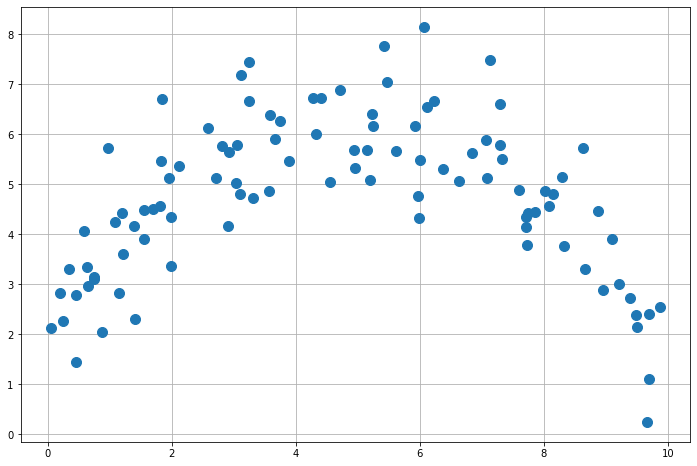

In [13]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(12,8),facecolor='w')
plt.plot(x2,y2,linestyle='',marker='o',markersize=10)
plt.show()

## Exact solution for a univariate regression

Our model is $Q(\mathbf{x},\mathbf{w})$ is $w_0+w_1x_i$. We would like to minimize the MSE:
$$
\text{Min. } \displaystyle{\left(\sum_i (y_i - Q(x_i,\mathbf{w}))^2\right)} \; \text{  where  } \; Q(x_i,\mathbf{w}) = w_0 + w_1x_i
$$

The exact solution for is available as:

$$
w_1 = \displaystyle{\frac{\sum(x_i-\langle x\rangle)(y_i-\langle y\rangle)}{\sum(x_i-\langle x\rangle)^2}} \;\text{ and } \; w_0 = \langle y\rangle - w_1\cdot\langle x\rangle
$$

### Exercise 1: implement the exact solution to solve for 
Let's implement and see how it works

In [19]:
w0,w1=0,0
### Your code below ###
w1 = np.sum((x-np.mean(x))*(y - np.mean(y))) / np.sum((x - np.mean(x))**2)
w0 = np.mean(y) - w1 * np.mean(x)
#######################
print('Analytical solution for w0',w0,'and w1',w1)

Analytical solution for w0 1.6699474504417484 and w1 1.973095351340853


## Gradient descent

Another approach to the solution is to use a _Gradient Descent_ technique as we covered in the lecture. In this case, we compute the error (i.e. MSE) and update the weights according to the equation:
$$
w_{\text{new}} = w - \lambda\nabla_{\mathbf{w}} \mathcal{L}
$$
First of all, let's use a bias trick. Our data = input feature vector $\mathbf{x}$ has only 1 feature. If we expand to $\mathbf{X}$ and add an identity as the second feature, we can write
$$
Q(\mathbf{x},\mathbf{w}) = \mathbf{X}\cdot\mathbf{w}
$$
A gradient for a linear regression is also covered in the lecture:
$$
\nabla_{\mathbf{w}}\mathcal{L} = -2\left(\mathbf{y} - Q(\mathbf{X},\mathbf{w})\right)\cdot\mathbf{X}
$$

Let's try to implement on our own!

### Model base class
In this notebook we will define two linear models. To save our time (sorry, actually, for your practice), let's define a common base class so that most functionalities as a machine learning model can be shared. Here's the base class definition.

In [ ]:
class linear_model_base:
    '''
    The base class for linear models in this notebook.
    This class (and its inherited children) implements 4 core functions.
      1. forward computes the model prediction (and loss, if label is provided).
      2. compute_loss calculates the loss and gradient given the data and label using the current parameters (weights).
      3. backward update the gradient which is computed within forward (must call forward beforehand).
    '''
    def __init__(self,num_features,lr=0.001):
        '''
        ARGUMENTS:
        num_features ... is the number of regression targets. y=w0 + w1*x would be 2.
          lr ... is the learning rate fir a gradient update (optional)
        '''
        self._num_features = int(num_features)
        self._w = np.zeros(shape=(num_features),dtype=np.float32)
        self._lr = float(lr)
        self._grad = None
                
    def forward(self,x,y=None):
        '''
        This function computes and returns a prediction. If an optional label information
        is given, also returns the loss value and calculates the gradient internally.
        ARGUMENTS:
          x ... is input data of the shape [N,2] for N samples of instances [x_i,1] 
          y ... is label (optional)
        RETURNS:
          prediction ... model predicted values
          loss ... the current loss value for the input data (only if y input is provided)
        '''
        prediction = np.dot(x,self._w)
        if y is None: 
            return prediction
        loss, self._grad = self.compute_loss(x,y)
        return prediction,loss

    def compute_loss(self,x,y):
        '''
        This is a place holder function for computing the loss. The base class implements 0 gradient
        and invalid loss (-1).
        ARGUMENTS:
          x ... is input data of the shape [N,2] for N samples of instances [x_i,1]
          y ... is label
        RETURNS:
          loss, gradient
        '''
        return -1, 0.
    
    def backward(self):
        '''
        This function applies pre-computed gradients to update the model parameters (weights).
        '''
        if self._grad is None:
            raise SyntaxError('Must call forward before backward!')
        self._w = self._w - self._lr * (self._grad)
        self._grad=None


Note that we assumed the input data $x$ has a shape $(N,2)$ for $N$ data instances of $[x_i,\mathbb{1}]$.

It includes an extra identity constant in the features so that we can treat the constnat (i.e. "bias", $w_0$) term in a unified matrix formula.

### Exercise 2: implement a linear regression class
This class should inherit from `linear_model_base` and implement model-specific (MSE loss + linear regression) function definitions. 

Give a shot looking at equations we covered earlier!

In [ ]:
class linear_regression(linear_model_base):
    
    def compute_loss(self,x,y):
        '''
        Compute the MSE loss
        ARGUMENTS:
          x ... is input data of the shape [N,2] for N samples of instances [x_i,1]
          y ... is label
        RETURNS:
          loss, gradient
        '''
        # your code here
        
        return -1.,0.

### Train loop
Let's write a code to run the loop of optimization (training loop).  

In [ ]:
def train_gradient_descent(x,y,model,num_iterations=100):
    '''
    Run gradient descent for a provided model
    ARGUMENTS:
      x ... is input data of the shape [N,2] for N samples of instances [x_i,1]
      y ... input label
      model ... model to be optimized
      num_interations ... number of times parameters are updated
    RETURNS:
      loss ... an array of loss at each iteration
      ws ... an array of the model weights at each iteration
    '''
    # Make sure the data shape matches the model's parameter count and label count
    assert(x.shape[1]==model._w.shape[0])
    assert(x.shape[0]==y.shape[0])
    
    loss, ws = [],[]
    for idx in range(num_iterations):
            
        loss.append(model.forward(x,y)[1])
        ws.append(model._w)
        model.backward()
        
    return np.array(loss), np.array(ws)

Let's run the training! 

Just one last point: don't forget to add an identity column in the input data $x$ as it was assumed for the model input. 

In [ ]:
# Prepare the input
data_input = np.column_stack([np.ones(shape=(len(x),1),dtype=np.float32),x])
data_label = y
# Construct the model
model = linear_regression(2)

# Run the training
loss,ws = train_gradient_descent(data_input,data_label,model,100)

# Plot the loss
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(figsize=(12,8),facecolor='w')
plt.plot(loss,marker='o',markersize=10)
plt.yscale('log')
plt.show()

In [ ]:
import imageio
import io
import base64
from IPython.display import HTML

def make_plot(x,y,ws):
    
        fig,ax = plt.subplots(figsize=(12,8),facecolor='w')
        ax.plot(x,y,markersize=10,marker='o',linestyle='')
        xmin=np.min(x)
        xmax=np.max(x)
        ymin = ws[1]*xmin+ws[0]
        ymax = ws[1]*xmax+ws[0]
        ax.plot((xmin,xmax),(ymin,ymax),linewidth=2,color='red')
        ax.set_xlim((xmin,xmax))
        ax.set_ylim((0,np.max(y)))
        ax.set_ylabel('$y$ (response)',fontsize=18)
        ax.set_xlabel('$x$ (feature)',fontsize=18)
        ax.tick_params(labelsize=15)
        ax.grid()

        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./anime.gif', [make_plot(x,y,ws[i]) for i in range(len(ws))], fps=20)

video = io.open('anime.gif', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

### Loss surface

Let's try to visualize how the loss distribution looks over some range of weights look like + our gradient descent's stepping points


In [ ]:
# Compute the loss on the grid of w0 and w1 values
w0s = np.arange(-10,10,0.1)
w1s = np.arange(0,5,0.1)
grid = np.array(np.meshgrid(w0s,w1s,sparse=False)).reshape(2,-1)
loss_map = np.zeros(shape=(grid.shape[1]),dtype=np.float32)
for i in range(grid.shape[1]):
    model._w = grid[0,i],grid[1,i]
    loss_map[i] = model.compute_loss(data_input,data_label)[0]
loss_map = loss_map.reshape(len(w1s),len(w0s))

# Plot the map and final fit
from matplotlib.colors import LogNorm
fig,axes=plt.subplots(1,2,figsize=(18,6),facecolor='w')
# Plot the map
axes[0].contourf(w0s,w1s,loss_map,norm=LogNorm())
axes[0].plot(ws[:,0],ws[:,1],marker='o',linestyle='', markersize=4, color='magenta')
axes[0].set_xlabel('$w_0$',fontsize=18)
axes[0].set_ylabel('$w_1$',fontsize=18)
# Plot the fit
axes[1].plot(x,y,linestyle='',marker='o',markersize=10)
xmin,xmax=np.min(x),np.max(x)
ymin = ws[-1][1]*xmin+ws[-1][0]
ymax = ws[-1][1]*xmax+ws[-1][0]
axes[1].plot((xmin,xmax),(ymin,ymax),linewidth=2,color='red')
axes[1].set_xlabel('x (feature)',fontsize=18)
axes[1].set_ylabel('y (response)',fontsize=18)
for ax in axes:
    ax.grid()
    ax.tick_params(labelsize=15)
plt.show()


### Stochastic GD (Exercise 3)
Next, let's try to implement a stochastic GD. 


In [ ]:

def train_sgd(x,y,model,batch_size,num_iterations=100):
    '''
    Run mini-batch stochastic gradient descent for a provided model
    ARGUMENTS:
      x ... is input data of the shape [N,2] for N samples of instances [x_i,1]
      y ... input label
      model ... model to be optimized
      batch_size ... the batch size to be used for SGD.
      num_interations ... number of times parameters are updated
    RETURNS:
      loss ... an array of loss at each iteration
      ws ... an array of the model weights at each iteration
    '''
    assert(x.shape[1]==model._w.shape[0])
    assert(x.shape[0]==y.shape[0])
    assert(batch_size>0)
    loss, ws = [],[]
    
    # Your code here
        
    return np.array(loss), np.array(ws)

### Training SGD
Let's run it!

In [ ]:
# Prepare the input
data_input = np.column_stack([np.ones(shape=(len(x),1),dtype=np.float32),x])
data_label = y
# Construct the model
model = linear_regression(2)

# Run the training
loss,ws = train_sgd(x=data_input,
                    y=data_label,
                    model=model,
                    batch_size=5,
                    num_iterations=100)

# Plot the loss
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(figsize=(12,8),facecolor='w')
plt.plot(loss,marker='o',markersize=10)
plt.yscale('log')
plt.show()

In [ ]:
# Compute the loss on the grid of w0 and w1 values
w0s = np.arange(-10,10,0.1)
w1s = np.arange(0,5,0.1)
grid = np.array(np.meshgrid(w0s,w1s,sparse=False)).reshape(2,-1)
loss_map = np.zeros(shape=(grid.shape[1]),dtype=np.float32)
for i in range(grid.shape[1]):
    model._w = grid[0,i],grid[1,i]
    loss_map[i] = model.compute_loss(data_input,data_label)[0]
loss_map = loss_map.reshape(len(w1s),len(w0s))

# Plot the map and final fit
from matplotlib.colors import LogNorm
fig,axes=plt.subplots(1,2,figsize=(18,6),facecolor='w')
# Plot the map
axes[0].contourf(w0s,w1s,loss_map,norm=LogNorm())
axes[0].plot(ws[:,0],ws[:,1],marker='o',linestyle='', markersize=4, color='magenta')
axes[0].set_xlabel('$w_0$',fontsize=18)
axes[0].set_ylabel('$w_1$',fontsize=18)
# Plot the fit
axes[1].plot(x,y,linestyle='',marker='o',markersize=10)
xmin,xmax=np.min(x),np.max(x)
ymin = ws[-1][1]*xmin+ws[-1][0]
ymax = ws[-1][1]*xmax+ws[-1][0]
axes[1].plot((xmin,xmax),(ymin,ymax),linewidth=2,color='red')
axes[1].set_xlabel('x (feature)',fontsize=18)
axes[1].set_ylabel('y (response)',fontsize=18)
for ax in axes:
    ax.grid()
    ax.tick_params(labelsize=15)
plt.show()

### Exercise 4

Compare how the behavior of the parameter updates (magenta points in $w_0$ v.s. $w_1$ contour plot) between GD and SGD with a batch size 5. How do they behave differently? 

## Logistic Regression

Next, let's try a linear model on a simple classification task: we will generate two class of data points in 2D using a gaussian distribution with different mean values (+1 and -1).

In [ ]:
np.random.seed(123)
sample_stat = 2000
a = np.random.normal(1,1,sample_stat).reshape(int(sample_stat/2),2)
b = np.random.normal(-1,1,sample_stat).reshape(int(sample_stat/2),2)
a = np.column_stack([a,np.zeros(shape=(len(a)),dtype=np.float32)])
b = np.column_stack([b,np.ones(shape=(len(b)),dtype=np.float32)])
data = np.concatenate([a,b])
np.random.shuffle(data)
x,y = data[:,:2],data[:,2]

Visualize the dataset

In [ ]:
fig,ax=plt.subplots(figsize=(12,8),facecolor='w')
pos = y>0
neg = y<1
ax.plot(x[pos][:,0],x[pos][:,1],marker='o',markersize=6,linestyle='',color='red')
ax.plot(x[neg][:,0],x[neg][:,1],marker='x',markersize=6,linestyle='',color='blue')
plt.ylabel('$x_0$ ',fontsize=18)
plt.xlabel('$x_1$ ',fontsize=18)
plt.show()

### Exercise 5

Inherit from `linear_mode_base` and implement a `logistic_regression` class.

$$
\mathcal{L} = \frac{1}{m}\sum(-\mathbf{y}^T\cdot\log Q(\mathbf{x},\mathbf{w}) - (1-y)^T\cdot\log (1-Q(\mathbf{x},\mathbf{w}))
$$

$$
\nabla_{\mathbf{w}}\mathcal{L}=\mathbf{x}^T(Q(\mathbf{x},\mathbf{w}) - \mathbf{y})
$$

In [ ]:
class logistic_regression(linear_model_base):
    
    def compute_loss(self,x,y):
        '''
        Compute the MSE loss
        ARGUMENTS:
          x ... is input data of the shape [N,2] for N samples of instances [x_i,1]
          y ... is label
        RETURNS:
          loss, gradient
        '''
        # Your code here
        return -1, 0.

### Training your logistic regression model (Exercise 6)
Let's run a similar loop!

In [ ]:
# Your code here

### Plot the decision boundary line (Exercise 7)

Plot the decision boundary (i.e. a linear equation) and overlay on top of the data!

In [ ]:
# Your code here

### Sigmoid probability distribution

For fun, let's plot the sigmoid probability distribution like we tried for a linear regression's loss surface.

As long as it's clear where the decision boundaries are and you are plotting a sigmoid probability, it would be fine (so be artistic)!

In [ ]:
from matplotlib.colors import LogNorm

# Just for fun, this time let's make 2D histogram instead of meshgrid+contour
nx,ny=300,300
prob_map=np.zeros(shape=(nx*ny,3),dtype=np.float32)
vrange=((data_input[:,1].min(),data_input[:,1].max()),(data_input[:,2].min(),data_input[:,2].max()))
for i in range(nx):
    x0 = (vrange[0][1]-vrange[0][0])/nx * i + vrange[0][0]
    for j in range(ny):
        x1 = (vrange[1][1]-vrange[1][0])/ny * j + vrange[1][0]
        prob = abs(model.sigmoid(model.forward(np.array([1,x0,x1]))) - 0.5)
        prob_map[i*ny+j]=(x0,x1,prob)

fig,ax=plt.subplots(figsize=(12,8),facecolor='w')
# Plot the histogram 2d
ax.hist2d(prob_map[:,0],prob_map[:,1],bins=(nx,ny),weights=prob_map[:,2],cmap='inferno')
# Plot the data points
pos = y>0
neg = y<1
ax.plot(x[pos][:,0],x[pos][:,1],marker='o',markersize=6,linestyle='',color='red')
ax.plot(x[neg][:,0],x[neg][:,1],marker='x',markersize=6,linestyle='',color='blue')
plt.ylabel('$x_1$',fontsize=18)
plt.xlabel('$x_0$',fontsize=18)
plt.show()


### ROC curve (Exercise 8)

For this trained model, plot the ROC curve using a different score threshold value.

In [ ]:
# Your code here

## Linear regression using Pytorch

Hopefully you are very familiar with linear regression now. 

Let's now learn one more thing, Pytorch machine learning library, which we will use to play with neural networks later.

### Defining a model

First, let's define a model for a linear regression. 

In [ ]:
import torch 

class linear_regression(torch.nn.Module):
    
    def __init__(self,num_features):
        super(linear_regression,self).__init__()
        # Define a linear model with a bias term
        self._linear = torch.nn.Linear(num_features,1,bias=True)
        
    def forward(self,x):
        return self._linear(x)

...yes, that's it! 

In fact, as we can see, we don't even need to define our model as a class since pytorch already provides a model (`torch.nn.Linear`).

But we did it anyway as a practice to define our own model by inheriting from `torch.nn.Module` base class.

### Generate $y=ax+\epsilon$ dataset

Now let's make some data

In [ ]:
# Use the same data generation function we used before
a,b=2.0,1.5
x,y=sample_linear_regression(a,b,num_sample=100)

# Convert them into a torch input. Shape should be (N,F) where N=number of samples, F=features/labels
torch_input = torch.Tensor(x).view(-1,1)
torch_label = torch.Tensor(y).view(-1,1)

Next, let's define a loss and write a train loop

In [ ]:
def train_torch(model,num_iterations=100):
    # Create a MSE loss module
    criterion = torch.nn.MSELoss()
    # Create an optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

    # Now we run the training!
    loss_v=[]
    for idx in range(num_iterations): 

        # This is "forward" computation
        prediction = model(torch_input) 

        # Compute the loss
        loss = criterion(prediction, torch_label) 

        # Next, we call "backward" to update the weights.
        # Don't forget to reset the gradient each time we call "backward".
        optimizer.zero_grad() 
        loss.backward() 

        # Now let optimizer to "take a step"
        optimizer.step() 

        # Record the loss
        loss_v.append(loss.item())
        
    return loss_v

### Train a pytorch model

Create our model instance + train + plot the loss!

In [ ]:
# Create a model 
model = linear_regression(1) 

# Train
loss = train_torch(model)

# Plot the loss
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(figsize=(12,8),facecolor='w')
plt.plot(loss,marker='o',markersize=10)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('Iterations',fontsize=18)
plt.show()

### Check the parameter values

Check the trained parameter values

In [ ]:
print('Weight',model._linear.weight.item())
print('Bias',model._linear.bias.item())